<a href="https://colab.research.google.com/github/Ashish-Garg06/brain_tumour_identification_using_CNN/blob/main/medical_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# BRAIN TUMOR DETECTION - GOOGLE COLAB OPTIMIZED
# ============================================================

# ============================================================
# STEP 0: SETUP - Check GPU and Install Dependencies
# ============================================================

!nvidia-smi  # Check GPU availability

# Install required packages
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q numpy pandas scikit-learn matplotlib opencv-python pillow tqdm

# Check PyTorch GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# ============================================================
# STEP 1: Mount Google Drive
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

# Create directories
import os
os.makedirs('/content/drive/MyDrive/brain_tumor_project', exist_ok=True)
os.makedirs('/content/brain_tumor_dataset', exist_ok=True)

print("Google Drive mounted successfully!")

Fri Nov 28 13:06:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ============================================================
# STEP 2: Download Dataset from Kaggle
# ============================================================

# Upload kaggle.json to Colab first:
# Go to https://www.kaggle.com/account, create API token,
# and upload the kaggle.json file when prompted

from google.colab import files

# If kaggle.json not uploaded, upload it
import os
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Upload your kaggle.json file:")
    uploaded = files.upload()
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.system('cp kaggle.json /root/.kaggle/')
    os.system('chmod 600 /root/.kaggle/kaggle.json')

# Download dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/brain_tumor_dataset

# Extract dataset
import zipfile
zip_path = '/content/brain_tumor_dataset/brain-tumor-mri-dataset.zip'
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/brain_tumor_dataset')
    print("Dataset extracted successfully!")



Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.61GB/s]
Dataset extracted successfully!


In [3]:
# ============================================================
# STEP 3: Import Libraries
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")



Using device: cuda


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
# ============================================================
# STEP 4: Data Preprocessing & Loading
# ============================================================

class BrainTumorDataset(Dataset):
    """Custom dataset for brain tumor MRI images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


def load_dataset_colab(data_dir, test_size=0.2, batch_size=32):
    """Load brain tumor dataset for Colab (optimized)"""

    from torchvision import transforms

    class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

    image_paths = []
    labels = []

    train_path = os.path.join(data_dir, 'Training')

    print("Loading dataset...")
    for class_name in class_names:
        class_dir = os.path.join(train_path, class_name)

        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found")
            continue

        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])

    image_paths = np.array(image_paths)
    labels = np.array(labels)

    # Stratified split
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, random_state=42, stratify=labels
    )

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
    test_dataset = BrainTumorDataset(test_paths, test_labels, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"✓ Training samples: {len(train_dataset)}")
    print(f"✓ Testing samples: {len(test_dataset)}")
    print(f"✓ Classes: {class_names}")

    return train_loader, test_loader, class_names

# Load dataset
DATA_DIR = '/content/brain_tumor_dataset'
train_loader, test_loader, class_names = load_dataset_colab(DATA_DIR, batch_size=32)

Using device: cuda
Loading dataset...
✓ Training samples: 4569
✓ Testing samples: 1143
✓ Classes: ['glioma', 'meningioma', 'pituitary', 'notumor']


In [7]:
# ============================================================
# STEP 5: Build CNN Model (Optimized for Colab)
# ============================================================

class BrainTumorCNN(nn.Module):
    """Optimized CNN for Colab (fewer parameters, faster training)"""

    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        # Efficient architecture
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
model = BrainTumorCNN(num_classes=len(class_names)).to(DEVICE)
print(f"✓ Model initialized on {DEVICE}")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")


✓ Model initialized on cuda
✓ Total parameters: 570,628


In [8]:
# ============================================================
# STEP 6: Training Function (Optimized for Colab)
# ============================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def validate(model, test_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy



In [11]:
# ============================================================
# STEP 7: Train Model
# ============================================================

NUM_EPOCHS = 15  # Reduced for Colab time limits
LEARNING_RATE = 0.001
BATCH_SIZE = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'─'*60}")
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"{'─'*60}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, test_acc = validate(model, test_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    scheduler.step(test_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    # Early stopping
    if epoch > 5 and test_acc < max(test_accs[:-1]):
        print("Early stopping triggered!")


STARTING TRAINING


────────────────────────────────────────────────────────────
Epoch [1/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.8234 | Train Acc: 67.41%
Test Loss: 1.2420 | Test Acc: 48.03%

────────────────────────────────────────────────────────────
Epoch [2/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.6855 | Train Acc: 72.90%
Test Loss: 0.5889 | Test Acc: 77.87%

────────────────────────────────────────────────────────────
Epoch [3/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.5863 | Train Acc: 77.83%
Test Loss: 1.5179 | Test Acc: 47.16%

────────────────────────────────────────────────────────────
Epoch [4/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.5299 | Train Acc: 80.06%
Test Loss: 1.5039 | Test Acc: 48.91%

────────────────────────────────────────────────────────────
Epoch [5/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.4864 | Train Acc: 82.23%
Test Loss: 1.5370 | Test Acc: 43.66%

────────────────────────────────────────────────────────────
Epoch [6/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.4186 | Train Acc: 85.23%
Test Loss: 2.7022 | Test Acc: 39.98%

────────────────────────────────────────────────────────────
Epoch [7/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.4104 | Train Acc: 85.16%
Test Loss: 2.0873 | Test Acc: 38.58%
Early stopping triggered!

────────────────────────────────────────────────────────────
Epoch [8/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3876 | Train Acc: 86.17%
Test Loss: 0.8179 | Test Acc: 71.04%
Early stopping triggered!

────────────────────────────────────────────────────────────
Epoch [9/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3587 | Train Acc: 87.31%
Test Loss: 0.3039 | Test Acc: 89.33%

────────────────────────────────────────────────────────────
Epoch [10/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3403 | Train Acc: 87.77%
Test Loss: 0.3471 | Test Acc: 87.66%
Early stopping triggered!

────────────────────────────────────────────────────────────
Epoch [11/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3308 | Train Acc: 88.22%
Test Loss: 0.3002 | Test Acc: 89.76%

────────────────────────────────────────────────────────────
Epoch [12/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3283 | Train Acc: 87.98%
Test Loss: 0.2700 | Test Acc: 89.85%

────────────────────────────────────────────────────────────
Epoch [13/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3213 | Train Acc: 88.75%
Test Loss: 0.3121 | Test Acc: 88.45%
Early stopping triggered!

────────────────────────────────────────────────────────────
Epoch [14/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3145 | Train Acc: 88.88%
Test Loss: 0.4830 | Test Acc: 81.10%
Early stopping triggered!

────────────────────────────────────────────────────────────
Epoch [15/15]
────────────────────────────────────────────────────────────


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3143 | Train Acc: 89.01%
Test Loss: 0.2651 | Test Acc: 90.11%


In [13]:
# ============================================================
# STEP 8: Save Model
# ============================================================

model_save_path = '/content/drive/MyDrive/brain_tumor_project/brain_tumor_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")



Model saved to: /content/drive/MyDrive/brain_tumor_project/brain_tumor_model.pth


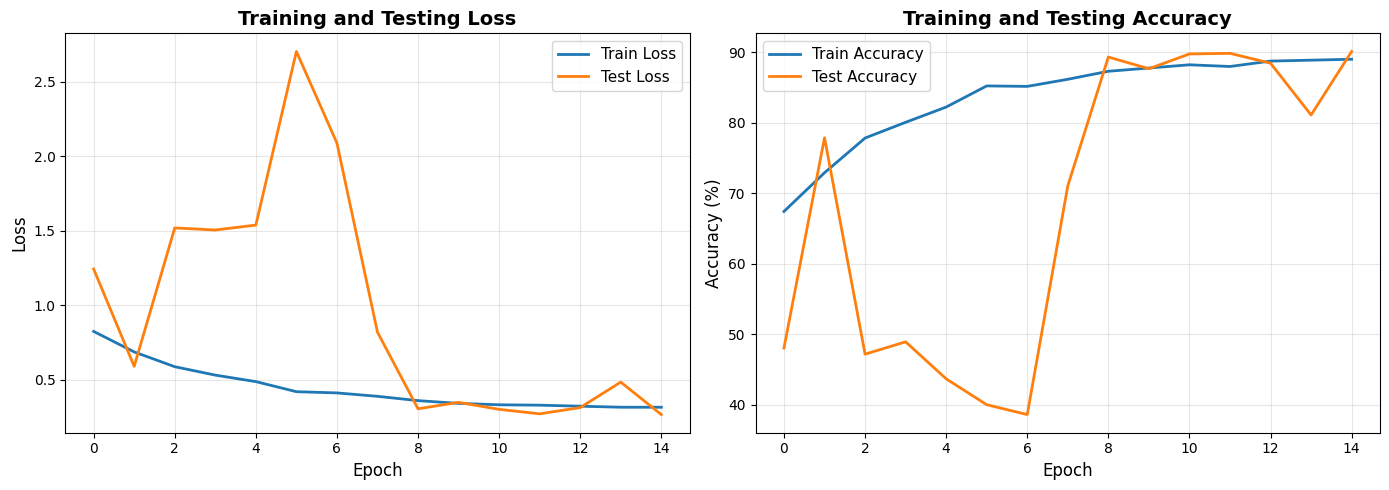

Training history saved!
Best Test Accuracy: 90.11%


In [14]:
# ============================================================
# STEP 9: Plot Results
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Testing Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Testing Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/brain_tumor_project/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history saved!")
print(f"Best Test Accuracy: {max(test_accs):.2f}%")



In [16]:
# ============================================================
# STEP 10: Inference on Test Images
# ============================================================

import torch.nn.functional as F

def predict_image(image_path, model, class_names, device):
    """Predict on a single image"""
    from torchvision import transforms

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_pct = confidence.item() * 100

    all_probs = {class_names[i]: probabilities[0][i].item() * 100 for i in range(len(class_names))}

    return predicted_class, confidence_pct, all_probs

# Test on a few random images
print("" + "="*60)
print("PREDICTIONS ON TEST IMAGES")
print("="*60 + "")

test_path = os.path.join(DATA_DIR, 'Testing')
sample_images = []

for class_name in class_names:
    class_dir = os.path.join(test_path, class_name)
    if os.path.exists(class_dir):
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            sample_images.append(os.path.join(class_dir, images[0]))

for img_path in sample_images[:4]:
    pred_class, conf, probs = predict_image(img_path, model, class_names, DEVICE)
    print(f"Image: {os.path.basename(img_path)}")
    print(f"  Prediction: {pred_class} ({conf:.2f}%)")
    for cls, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
        print(f"    {cls}: {prob:.2f}%")
    print()

print("✓ Training completed successfully!")
print(f"✓ Model saved to Google Drive: {model_save_path}")

PREDICTIONS ON TEST IMAGES
Image: Te-gl_0277.jpg
  Prediction: meningioma (84.43%)
    meningioma: 84.43%
    glioma: 15.40%
    pituitary: 0.17%
    notumor: 0.00%

Image: Te-me_0013.jpg
  Prediction: notumor (72.91%)
    notumor: 72.91%
    meningioma: 16.85%
    pituitary: 6.42%
    glioma: 3.82%

Image: Te-pi_0233.jpg
  Prediction: pituitary (98.53%)
    pituitary: 98.53%
    meningioma: 1.29%
    notumor: 0.14%
    glioma: 0.04%

Image: Te-no_0230.jpg
  Prediction: notumor (99.81%)
    notumor: 99.81%
    meningioma: 0.14%
    glioma: 0.03%
    pituitary: 0.02%

✓ Training completed successfully!
✓ Model saved to Google Drive: /content/drive/MyDrive/brain_tumor_project/brain_tumor_model.pth


In [17]:
import cv2

def compute_gradcam(model, target_layer, input_image, target_category, device):
    """Computes Grad-CAM heatmap for a given image and model."""

    model.eval() # Set model to evaluation mode

    # Store activations and gradients
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks on the target layer
    # Assuming target_layer is an nn.Module (e.g., conv3[0] for the Conv2d layer within the Sequential block)
    if isinstance(target_layer, nn.Sequential):
        hook_handle_f = target_layer[-2].register_forward_hook(forward_hook) # Get output of last Conv2d before ReLU
        hook_handle_b = target_layer[-2].register_backward_hook(backward_hook)
    else:
        hook_handle_f = target_layer.register_forward_hook(forward_hook)
        hook_handle_b = target_layer.register_backward_hook(backward_hook)

    # Perform forward pass
    output = model(input_image.to(device))

    # Zero gradients
    model.zero_grad()

    # Create one-hot vector for the target category
    one_hot_output = torch.zeros_like(output).to(device)
    one_hot_output[0][target_category] = 1 # Assuming batch size of 1 for single image prediction

    # Perform backward pass
    output.backward(gradient=one_hot_output, retain_graph=True)

    # Retrieve activations and gradients
    # activations and gradients will contain list of tensors, take the last one added
    activation = activations[-1].cpu().data.numpy()[0] # [0] for batch
    gradient = gradients[-1].cpu().data.numpy()[0]   # [0] for batch

    # Remove hooks
    hook_handle_f.remove()
    hook_handle_b.remove()

    # Calculate neuron importance weights (alpha_k)
    weights = np.mean(gradient, axis=(1, 2)) # Global average pooling

    # Compute Grad-CAM heatmap
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = np.maximum(cam, 0) # Apply ReLU to only consider positive contributions

    # Resize heatmap to original image size and normalize
    input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    h, w, _ = input_image_np.shape
    cam = cv2.resize(cam, (w, h))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8) # Normalize to 0-1

    return cam

print("✓ `compute_gradcam` function defined.")

✓ `compute_gradcam` function defined.


**Reasoning**:
Now that the `compute_gradcam` function is defined, I will create a function to visualize the Grad-CAM heatmap overlaid on the original image, along with the model's prediction. This function will be used to demonstrate Grad-CAM on sample test images.



In [18]:
def visualize_gradcam(image_path, model, class_names, device, target_layer):
    """Visualizes Grad-CAM heatmap on an image."""

    from torchvision import transforms

    # Original image for display
    original_img = Image.open(image_path).convert('RGB')

    # Preprocess image for model input
    preprocess_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess_transform(original_img).unsqueeze(0).to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_class_name = class_names[predicted_idx.item()]
    predicted_confidence = confidence.item()

    # Compute Grad-CAM heatmap
    grad_cam_heatmap = compute_gradcam(model, target_layer, input_tensor, predicted_idx.item(), device)

    # Convert original image to NumPy for display
    original_img_np = np.array(original_img)

    # Apply heatmap to original image
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * grad_cam_heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.resize(heatmap_colored, (original_img_np.shape[1], original_img_np.shape[0]))

    # Overlay heatmap on original image
    superimposed_img = heatmap_colored * 0.4 + original_img_np * 0.6 # Adjust alpha for blending
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_np)
    plt.title(f"Original\nPredicted: {predicted_class_name} ({predicted_confidence:.2%})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay\nTarget Layer: {target_layer.__class__.__name__}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return predicted_class_name, predicted_confidence, grad_cam_heatmap

print("✓ `visualize_gradcam` function defined.")


✓ `visualize_gradcam` function defined.



GRAD-CAM VISUALIZATION ON SAMPLE TEST IMAGES

Visualizing Grad-CAM for 4 sample images using target layer: ReLU

--- Image 1/4: Te-gl_0277.jpg ---


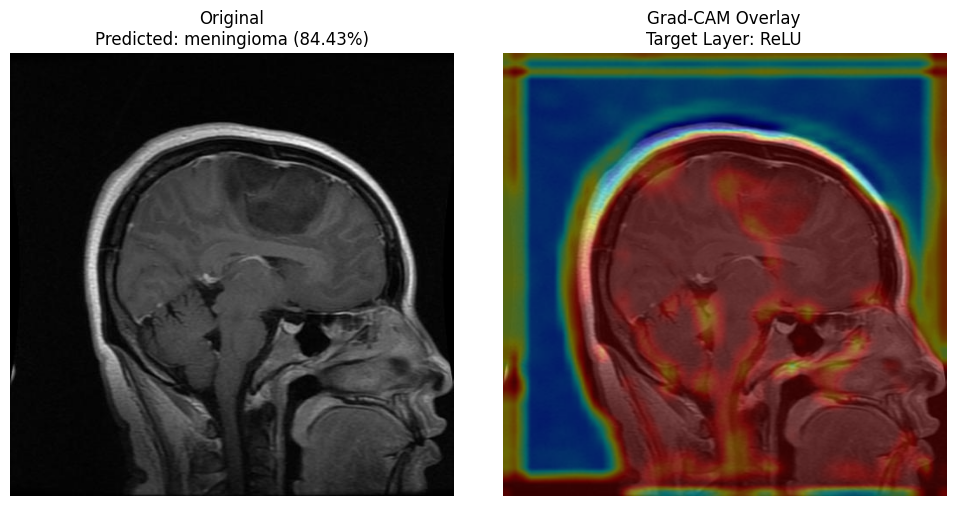

Model Prediction: meningioma with confidence: 84.43%

--- Image 2/4: Te-me_0013.jpg ---


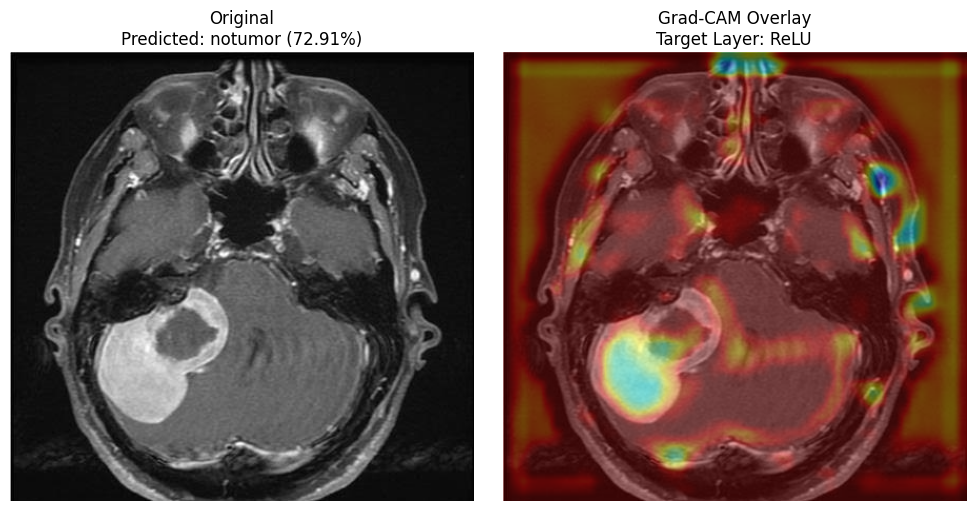

Model Prediction: notumor with confidence: 72.91%

--- Image 3/4: Te-pi_0233.jpg ---


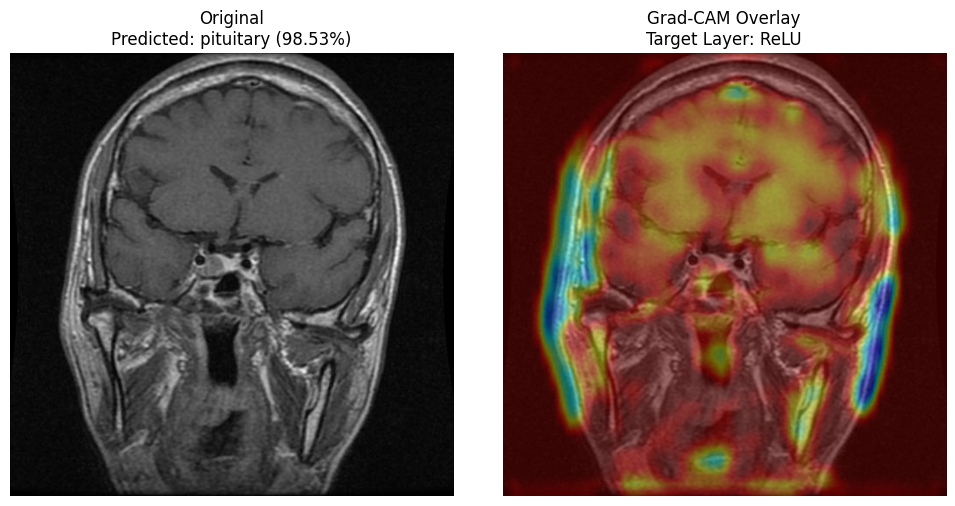

Model Prediction: pituitary with confidence: 98.53%

--- Image 4/4: Te-no_0230.jpg ---


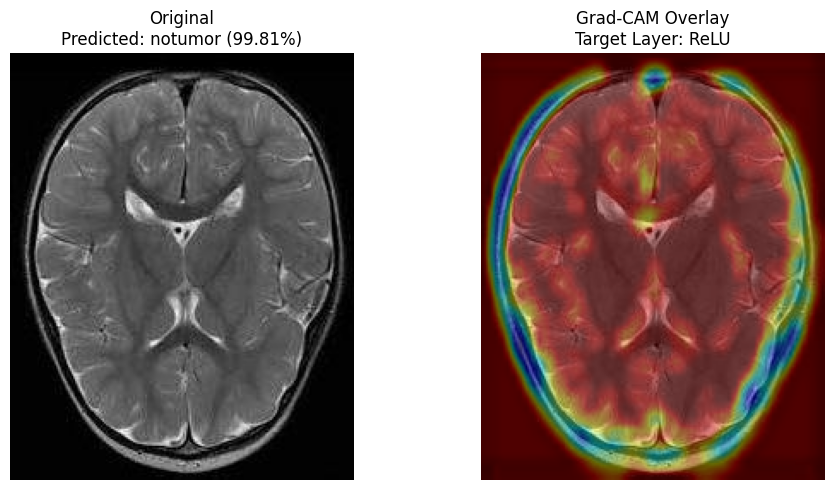

Model Prediction: notumor with confidence: 99.81%

✓ Grad-CAM visualization complete.


In [19]:
print("\n" + "="*60)
print("GRAD-CAM VISUALIZATION ON SAMPLE TEST IMAGES")
print("="*60 + "\n")

# Choose a target convolutional layer for Grad-CAM
# For our BrainTumorCNN, a good target would be the last convolutional layer before pooling/FC layers.
# This corresponds to model.conv3[-1] (the last ReLU in the conv3 block) or model.conv3[-2] (the last Conv2d layer)
# Let's use the last Conv2d layer in conv3 for better visualization of features.
target_layer = model.conv3[-2] # This is the nn.Conv2d(128, 256, kernel_size=3, padding=1) layer

# Select a few random test images for visualization
# We'll reuse the sample_images list generated in STEP 10

if 'sample_images' not in locals():
    # If for some reason sample_images is not available, regenerate it
    test_path = os.path.join(DATA_DIR, 'Testing')
    sample_images = []
    for class_name in class_names:
        class_dir = os.path.join(test_path, class_name)
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if images:
                # Take a random sample or the first few
                sample_images.extend([os.path.join(class_dir, img) for img in images[:2]]) # Take 2 from each class

print(f"Visualizing Grad-CAM for {len(sample_images)} sample images using target layer: {target_layer.__class__.__name__}")

for i, img_path in enumerate(sample_images[:4]): # Limit to first 4 for brevity
    print(f"\n--- Image {i+1}/{len(sample_images[:4])}: {os.path.basename(img_path)} ---")
    predicted_class, confidence, _ = visualize_gradcam(img_path, model, class_names, DEVICE, target_layer)
    print(f"Model Prediction: {predicted_class} with confidence: {confidence:.2%}")

print("\n✓ Grad-CAM visualization complete.")
